### Example for phonon calculation of diamond using finite-displacement with ASE+Conquest

In [1]:
import os
import numpy as np

from ase.build import bulk
from ase.spacegroup import crystal
from ase.phonons import Phonons

from ase.calculators.conquest import Conquest

In [2]:
%%bash 
ase --version

ase-3.23.0b1


#### Directory for storing calculation files

In [3]:
working_directory = 'data/cq_example_diamond_phonon_ase'

#### Generate diamond cell ; enforced to be conventional by using `cubic=True`

In [4]:
atoms = bulk('C', crystalstructure='diamond', a=3.5548, cubic=True)

#### Define Conquest environment variables for ASE

In [5]:
CQ_ROOT = ''
CQ_NPROC= 1

In [6]:
os.environ['ASE_CONQUEST_COMMAND'] = 'mpirun -np '+str(CQ_NPROC)+' '+CQ_ROOT+'Conquest'
os.environ['CQ_PP_PATH']           = CQ_ROOT+'/pseudo-and-pao/'
os.environ['CQ_GEN_BASIS_CMD']     = CQ_ROOT+'/tools/BasisGeneration/MakeIonFiles'

#### Define Conquest PAO basis

In [7]:
basis = {'C' : { 'gen_basis' : False}}

#### Setup Conquest as a calculator

In [8]:
calc = Conquest(basis=basis,
                directory    = working_directory,
                scf_tolerance= 1e-8, # default 1e-6
                grid_cutoff  =  120) # default 100 Ha

input basis:
C {'gen_basis': False}


#### Setup Phonon calculation with small displacement
> size of the the supercell is $(4\times 4\times 4)$ with a displacement of 0.05 Ang. ; `ph_dir` is the directory containing the results

In [9]:
N  = 4
ph_dir = 'phonon_run4'
#phonon_run4:
#** FD using Conquest+ASE ; cell parameter = 3.5548 ; TZTP basis !
#** supercell 4*4*4 + step 0.05
#** scf_tolerance= 1e-8 # default 1e-6
#** grid_cutoff  =  120 # default 100
ph     =  Phonons(atoms, calc, supercell=(N, N, N), delta=0.05, name=working_directory+'/'+ph_dir)

#### Run Phonon calculation

In [10]:
# The phonon calculation must have been run and ph_dir is inside working_directory

#### Read forces and assemble the dynamical matrix

In [11]:
ph.read(acoustic=True)

#### Print lattice description including special k-points

In [12]:
latt = atoms.cell.get_bravais_lattice()
print(latt.description())

CUB(a=3.5548)
  Variant name: CUB
  Special point names: GXRM
  Default path: GXMGRX,MR

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    X   0.0000  0.5000  0.0000
    R   0.5000  0.5000  0.5000
    M   0.5000  0.5000  0.0000



#### Choose the k-path and plot it

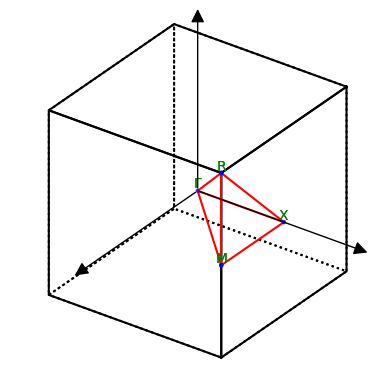

<Axes3DSubplot:>

In [13]:
path = 'GXMGRX,MR'
nkps = 100

kpath = atoms.cell.bandpath(path, npoints=nkps)
latt.plot_bz(show=True,path=path)

#### Recover the max value of the path (for renormalisation purpose)

In [14]:
array1, array2, list = kpath.get_linear_kpoint_axis(eps=1e-6)
xmax = np.max(array2)

#### Compute band structure and DOS

In [15]:
bs  = ph.get_band_structure(kpath)
dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.743e-04*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.743e-04*i)


#### Plot band structure and DOS ; add data from DFPT obtained with Quantum Espresso

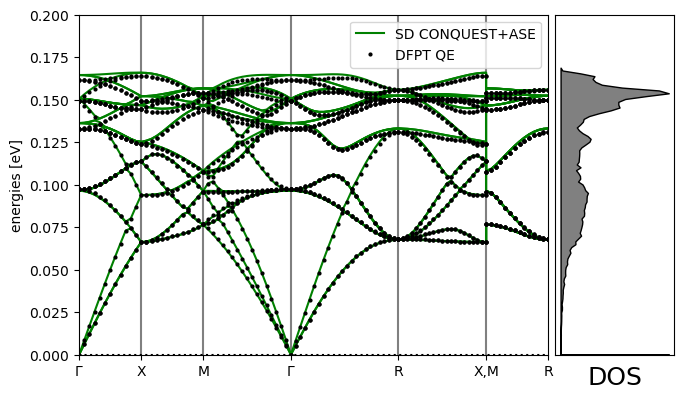

In [18]:
import matplotlib.pyplot as plt
from scipy.constants import h, c, e
fig = plt.figure(1, figsize=(7, 4))
ax  = fig.add_axes([.12, .07, .67, .85])

emax = 0.2
bs.plot(ax=ax, emin=0.0, emax=emax, label='SD CONQUEST+ASE')

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

#####################################################################
# Add results from Quantum Espresso
#    * the result file 'phonon.bands.xmgr' is located in work_dir
#    * it contains data generated by plotbands.x in XmGrace format
#    * the x-axis is adapted to ASE kpath norm for direct comparison
#    * the y-axis unit, cm^-1, is converted to eV
#####################################################################
file = open(working_directory+'/phonon.DFPT.bands_run2.xmgr','r')
#phonon.DFPT.bands_run2:
#** Pseudo-dojo: nc-sr-05_pbe_standard_upf
#** DFPT using QE on top of vc-relax ; cell parameter = 3.5548
#** 4*4*4 q-points
#
file.readline()
x = [ ] ; y = [ ]
for line in file:
    words = line.split()    
    if ( words != [] ):        
        x.append( float(words[0]) )
        y.append( float(words[1]) )
x = np.array(x)
y = np.array(y)

x = x*xmax/np.amax(x)
y = y*h*c/e/0.01
#
ax.plot(x,y,linestyle='',marker='o',markersize=2,color='k',label='DFPT QE')
#

ax.legend()
fig.savefig('cq_diamond_phonon.pdf')

## 